# 1.7c: Cluster Spherical Coordinates

Map the cluster's internal structure using spherical coordinates centered at the cluster centroid.

**Approach:**
1. Center cluster at centroid: `W_centered = W_cluster - centroid`
2. Find 3 dimensions with highest variance (no PCA - stay aligned with bfloat16 lattice)
3. Use those dimensions as orthonormal basis (they're guaranteed orthogonal in standard basis)
4. Project to spherical coordinates (r, lat, lon)
5. Plot r histogram to see core vs outliers
6. Save spherical coords and basis for future visualization

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Histogram settings
N_BINS = 100
DPI = 200

## Imports

In [2]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file, save_file
from pathlib import Path

## Load Data

In [3]:
# Load W
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W = load_file(W_path)["W"].to(torch.float32)

print(f"Loaded W from {W_path}")
print(f"  Shape: {W.shape}")

# Load cluster data from 1.6a
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_mask.safetensors")
cluster_data = load_file(cluster_path)

cluster_mask = cluster_data["cluster_mask"].to(torch.bool)
cluster_token_ids = cluster_data["cluster_token_ids"].to(torch.int64)
centroid = cluster_data["centroid"].to(torch.float32)
n_cluster = cluster_data["n_cluster"].item()

print(f"\nLoaded cluster from {cluster_path}")
print(f"  Cluster size: {n_cluster:,} tokens")
print(f"  Centroid norm: {centroid.norm().item():.8f}")

Loaded W from ../tensors/Qwen3-4B-Instruct-2507/W.safetensors
  Shape: torch.Size([151936, 2560])

Loaded cluster from ../tensors/Qwen3-4B-Instruct-2507/1.6a_cluster_mask.safetensors
  Cluster size: 2,248 tokens
  Centroid norm: 0.37091014


## Extract and Center Cluster

In [4]:
# Get cluster embeddings
W_cluster = W[cluster_mask]

print(f"Extracted {W_cluster.shape[0]:,} cluster embeddings")
print(f"  Dimensionality: {W_cluster.shape[1]:,}")

# Center at centroid
W_centered = W_cluster - centroid

print(f"\n✓ Centered cluster at centroid")
print(f"  Mean of centered cluster: {W_centered.mean(dim=0).norm().item():.2e} (should be ~0)")

Extracted 2,248 cluster embeddings
  Dimensionality: 2,560

✓ Centered cluster at centroid
  Mean of centered cluster: 8.82e-04 (should be ~0)


## Find High-Variance Dimensions

In [5]:
print("Finding dimensions with highest variance...\n")

# Compute variance per dimension
variances = W_centered.var(dim=0)  # (2560,)

# Find top 3 dimensions
top_indices = variances.argsort(descending=True)[:3]

# Assign to spherical basis (following convention: 2, 1, 3)
north_idx = top_indices[1].item()      # 2nd highest variance
meridian_idx = top_indices[0].item()   # Highest variance
equinox_idx = top_indices[2].item()    # 3rd highest variance

print(f"Top 3 dimensions by variance:")
print(f"  Meridian (1st): dimension {meridian_idx}, variance = {variances[meridian_idx].item():.8f}")
print(f"  North (2nd):    dimension {north_idx}, variance = {variances[north_idx].item():.8f}")
print(f"  Equinox (3rd):  dimension {equinox_idx}, variance = {variances[equinox_idx].item():.8f}")

print(f"\nThese dimensions are orthogonal by construction (standard basis).")

Finding dimensions with highest variance...

Top 3 dimensions by variance:
  Meridian (1st): dimension 492, variance = 0.00000488
  North (2nd):    dimension 1174, variance = 0.00000388
  Equinox (3rd):  dimension 1811, variance = 0.00000342

These dimensions are orthogonal by construction (standard basis).


## Project to Cartesian Coordinates

In [6]:
print("\nProjecting to Cartesian coordinates...\n")

# Extract coordinates (just slice the columns)
x = W_centered[:, meridian_idx]  # Longitude axis
y = W_centered[:, equinox_idx]   # Latitude-longitude plane
z = W_centered[:, north_idx]     # Latitude axis

print(f"✓ Extracted Cartesian coordinates")
print(f"  x range: [{x.min().item():.8f}, {x.max().item():.8f}]")
print(f"  y range: [{y.min().item():.8f}, {y.max().item():.8f}]")
print(f"  z range: [{z.min().item():.8f}, {z.max().item():.8f}]")


Projecting to Cartesian coordinates...

✓ Extracted Cartesian coordinates
  x range: [-0.04581451, 0.08553314]
  y range: [-0.06956482, 0.01399231]
  z range: [-0.00482178, 0.07464600]


## Convert to Spherical Coordinates

In [7]:
print("\nConverting to spherical coordinates...\n")

# Compute radius
r = torch.sqrt(x**2 + y**2 + z**2)

# Latitude (angle from xy-plane)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)

# Longitude (angle in xy-plane)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print(f"✓ Computed spherical coordinates")
print(f"\nRadius (r):")
print(f"  Min: {r.min().item():.8f}")
print(f"  Max: {r.max().item():.8f}")
print(f"  Median: {r.median().item():.8f}")
print(f"  Mean: {r.mean().item():.8f}")
print()
print(f"Latitude:")
print(f"  Range: [{lat_deg.min().item():.2f}°, {lat_deg.max().item():.2f}°]")
print()
print(f"Longitude:")
print(f"  Range: [{lon_deg.min().item():.2f}°, {lon_deg.max().item():.2f}°]")


Converting to spherical coordinates...

✓ Computed spherical coordinates

Radius (r):
  Min: 0.00002158
  Max: 0.11260527
  Median: 0.00007553
  Mean: 0.00022649

Latitude:
  Range: [-75.96°, 72.86°]

Longitude:
  Range: [-172.85°, 179.17°]


## Radius Distribution Histogram


Plotting radius distribution...



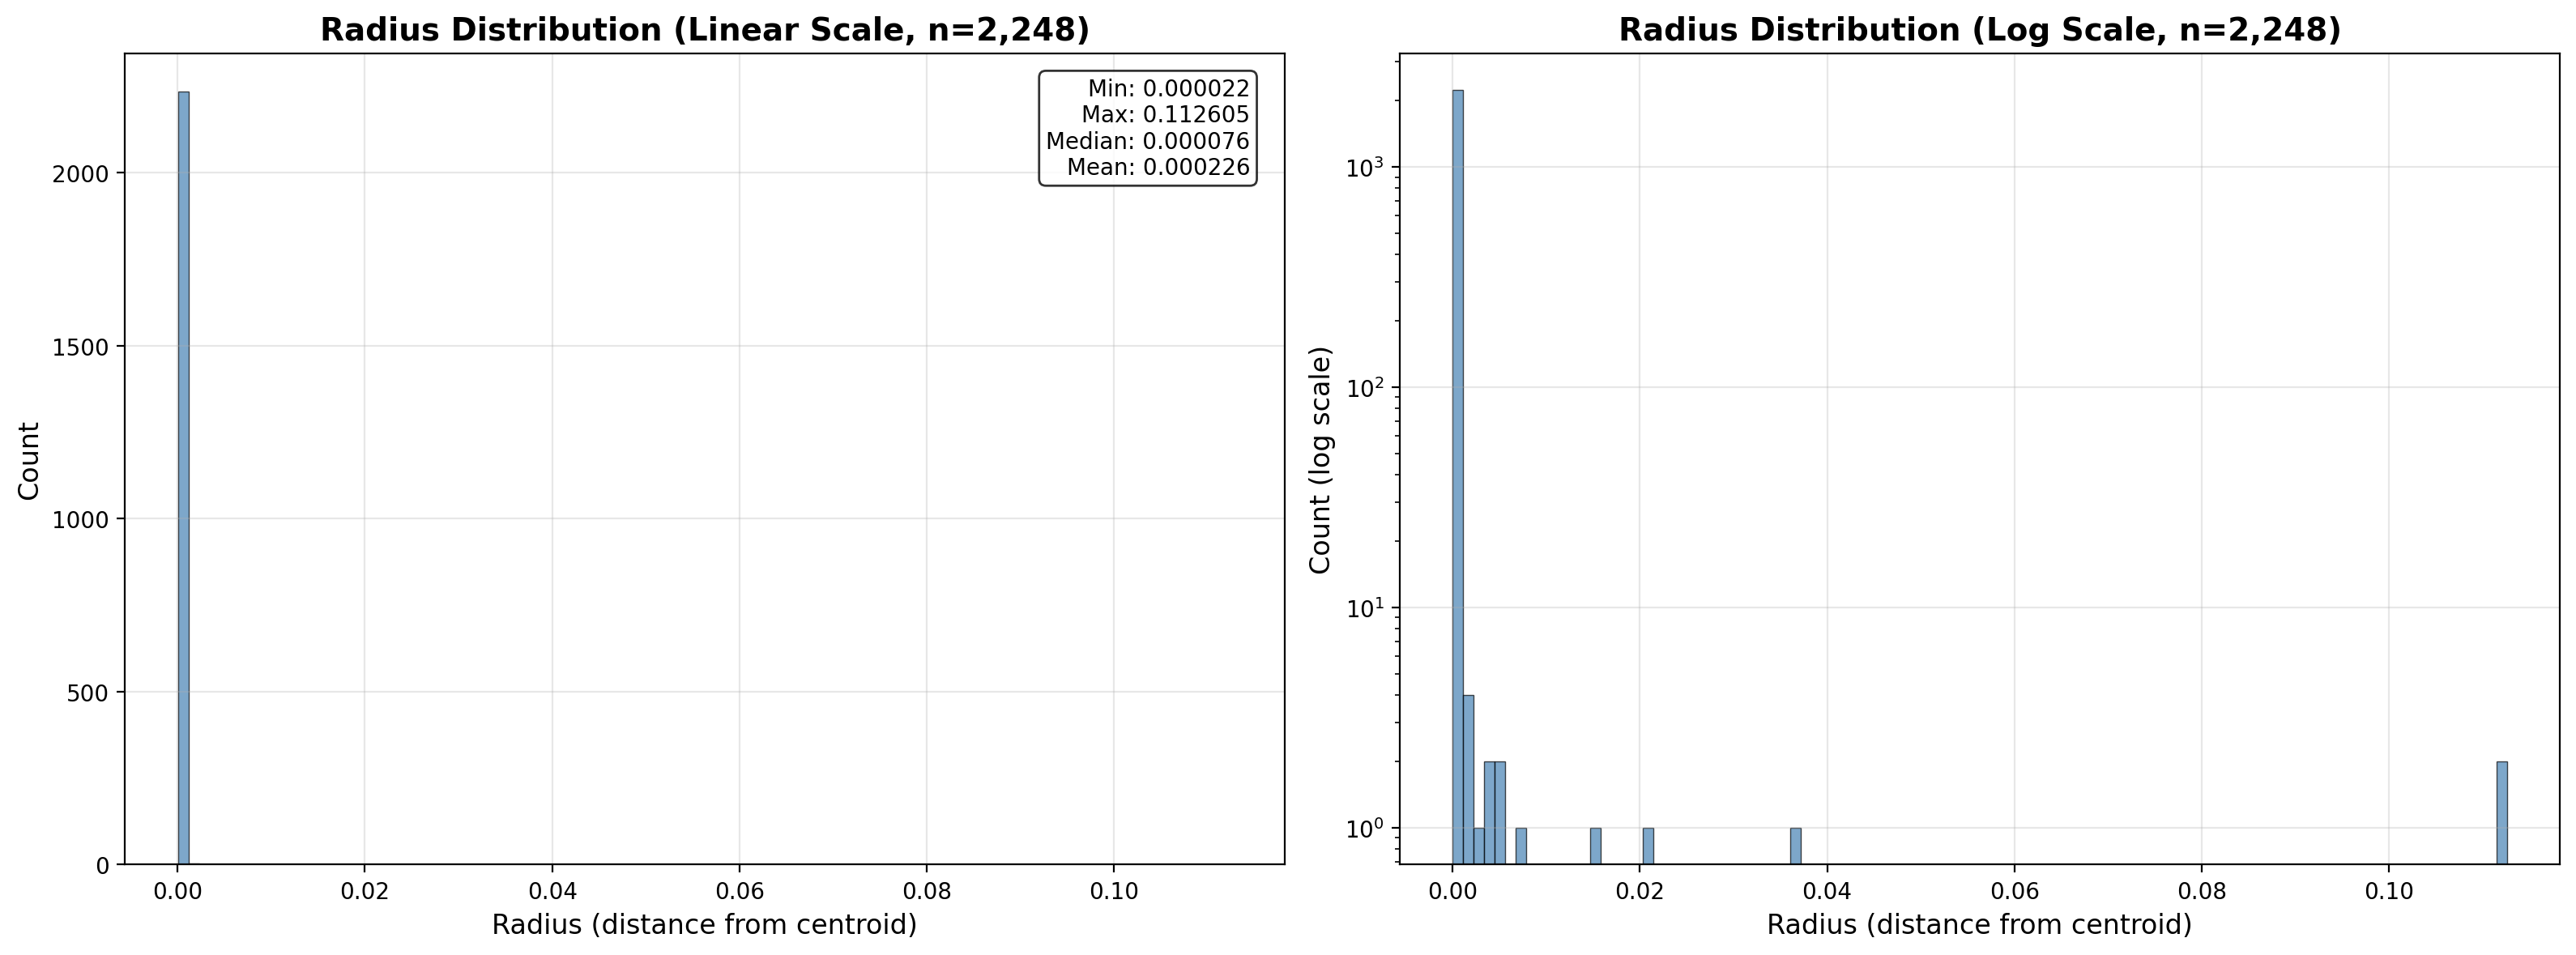

✓ Plotted radius distribution


In [8]:
print("\nPlotting radius distribution...\n")

# Convert to numpy
r_np = r.numpy()

# Create figure with two subplots: linear and log scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Linear scale
ax1.hist(r_np, bins=N_BINS, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Radius (distance from centroid)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Radius Distribution (Linear Scale, n={n_cluster:,})', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add statistics
stats_text = f"Min: {r.min().item():.6f}\n"
stats_text += f"Max: {r.max().item():.6f}\n"
stats_text += f"Median: {r.median().item():.6f}\n"
stats_text += f"Mean: {r.mean().item():.6f}"
ax1.text(0.97, 0.97, stats_text,
         transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Log scale (y-axis)
ax2.hist(r_np, bins=N_BINS, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Radius (distance from centroid)', fontsize=12)
ax2.set_ylabel('Count (log scale)', fontsize=12)
ax2.set_title(f'Radius Distribution (Log Scale, n={n_cluster:,})', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Plotted radius distribution")

## Identify Outliers

In [9]:
print("\nIdentifying outliers (tokens far from centroid)...\n")

# Sort by radius
sorted_indices = r.argsort(descending=True)

# Show top 20 most distant tokens
print("Top 20 tokens by distance from centroid:")
print(f"{'Rank':<6} {'Token ID':<10} {'Radius':<12} {'Latitude':<12} {'Longitude'}")
print("-" * 60)

for rank in range(min(20, n_cluster)):
    idx = sorted_indices[rank]
    token_id = cluster_token_ids[idx].item()
    radius = r[idx].item()
    lat = lat_deg[idx].item()
    lon = lon_deg[idx].item()
    
    print(f"{rank+1:<6} {token_id:<10} {radius:<12.8f} {lat:<12.2f} {lon:.2f}°")


Identifying outliers (tokens far from centroid)...

Top 20 tokens by distance from centroid:
Rank   Token ID   Radius       Latitude     Longitude
------------------------------------------------------------
1      71473      0.11260527   28.88        -29.84°
2      48494      0.11184927   41.87        -123.37°
3      122347     0.03672947   14.84        156.79°
4      139809     0.02079694   19.46        146.09°
5      137722     0.01560331   2.69         -34.53°
6      148664     0.00753114   3.95         26.28°
7      141054     0.00515923   -69.16       -86.13°
8      76035      0.00472136   0.00         118.47°
9      141591     0.00427708   55.86        -59.11°
10     117971     0.00379758   49.77        -172.85°
11     138463     0.00248973   44.32        71.04°
12     138112     0.00166448   -47.17       -18.07°
13     143849     0.00162461   -4.31        -3.24°
14     117963     0.00157584   -18.05       -27.94°
15     135078     0.00155912   61.74        -53.72°
16     15129

## Save Results

In [10]:
print("\nSaving spherical coordinates and basis...\n")

# Save to safetensors
output_path = Path(f"../tensors/{MODEL_NAME}/1.7c_cluster_spherical.safetensors")
output_path.parent.mkdir(parents=True, exist_ok=True)

save_file({
    # Spherical coordinates
    "r": r,
    "lat_deg": lat_deg,
    "lon_deg": lon_deg,
    
    # Basis indices (which dimensions we used)
    "north_idx": torch.tensor([north_idx], dtype=torch.int32),
    "meridian_idx": torch.tensor([meridian_idx], dtype=torch.int32),
    "equinox_idx": torch.tensor([equinox_idx], dtype=torch.int32),
    
    # Metadata
    "n_cluster": torch.tensor([n_cluster], dtype=torch.int32),
    "cluster_token_ids": cluster_token_ids,
}, str(output_path))

print(f"✓ Saved to {output_path}")
print()
print("Saved tensors:")
print(f"  r: ({n_cluster},) - radial distances from centroid")
print(f"  lat_deg: ({n_cluster},) - latitudes in degrees")
print(f"  lon_deg: ({n_cluster},) - longitudes in degrees")
print(f"  north_idx: scalar - dimension {north_idx}")
print(f"  meridian_idx: scalar - dimension {meridian_idx}")
print(f"  equinox_idx: scalar - dimension {equinox_idx}")
print(f"  cluster_token_ids: ({n_cluster},) - token IDs")


Saving spherical coordinates and basis...

✓ Saved to ../tensors/Qwen3-4B-Instruct-2507/1.7c_cluster_spherical.safetensors

Saved tensors:
  r: (2248,) - radial distances from centroid
  lat_deg: (2248,) - latitudes in degrees
  lon_deg: (2248,) - longitudes in degrees
  north_idx: scalar - dimension 1174
  meridian_idx: scalar - dimension 492
  equinox_idx: scalar - dimension 1811
  cluster_token_ids: (2248,) - token IDs
